# 필요한 모듈 Import

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# GPU 사용가능 여부 체크
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# 하이퍼파라미터 설정 및 시드 고정

In [3]:
# 하이퍼파라미터 설정

EPOCHS = 400 # 반복 횟수
LR = 1e-2 # 학습률
BS = 16384 # 배치 크기
SEED = 41 # 랜덤 시드

In [4]:
# 함수를 정의하여 모든 시드를 사전에 고정시킴
# 앞에서 설정한 SEED(랜덤 시드) 사용

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED) # 앞서 설정한 시드 넘버로 시드 고정

# 데이터 로드

In [5]:
# train, val 데이터 로드 후 형태 파악

train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/val.csv')

train_df

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113837,284796,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,...,-0.944759,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,-0.169496,1.034857
113838,284797,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,...,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,0.530986,1.034881
113839,284798,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,-0.230699,1.034904
113840,284802,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,-0.269825,1.034939


In [6]:
val_df

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,10,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,22,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,63,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,69,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,83,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28457,284769,-0.546378,1.433992,-0.313252,0.926044,0.522388,-0.565669,1.066075,0.269799,-1.099446,...,0.778817,-0.175451,0.030397,0.018381,-0.395994,0.301655,0.173585,0.202753,1.034622,0
28458,284779,-0.764523,0.588379,-0.907599,-0.418847,0.901528,-0.760802,0.758545,0.414698,-0.730854,...,-0.431876,0.141759,0.587119,-0.200998,0.267337,-0.152951,-0.065285,0.810452,1.034693,0
28459,284790,-0.446951,1.302212,-0.168583,0.981577,0.578957,-0.605641,1.253430,-1.042610,-0.417116,...,0.305268,-0.148093,-0.038712,0.010209,-0.362666,0.503092,0.229921,0.537972,1.034763,0
28460,284801,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,...,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,-0.269964,1.034928,0


In [7]:
# 세부 정보 파악(결측 유무, 데이터 타입 등)

print(train_df.info(), val_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113842 entries, 0 to 113841
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      113842 non-null  int64  
 1   V1      113842 non-null  float64
 2   V2      113842 non-null  float64
 3   V3      113842 non-null  float64
 4   V4      113842 non-null  float64
 5   V5      113842 non-null  float64
 6   V6      113842 non-null  float64
 7   V7      113842 non-null  float64
 8   V8      113842 non-null  float64
 9   V9      113842 non-null  float64
 10  V10     113842 non-null  float64
 11  V11     113842 non-null  float64
 12  V12     113842 non-null  float64
 13  V13     113842 non-null  float64
 14  V14     113842 non-null  float64
 15  V15     113842 non-null  float64
 16  V16     113842 non-null  float64
 17  V17     113842 non-null  float64
 18  V18     113842 non-null  float64
 19  V19     113842 non-null  float64
 20  V20     113842 non-null  float64
 21  V21     11

In [8]:
# 분석에 불필요한 'ID' column 제거

train_df.drop(columns=['ID'], inplace=True) # inplace=True 필요!
val_df.drop(columns=['ID'], inplace=True)# 없으면 ID column 안없어짐

In [9]:
# column 제거 확인

train_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113837,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,8.655320,...,-0.944759,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,-0.169496,1.034857
113838,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,0.120908,...,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,0.530986,1.034881
113839,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,-0.230699,1.034904
113840,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,-0.269825,1.034939


In [10]:
val_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28457,-0.546378,1.433992,-0.313252,0.926044,0.522388,-0.565669,1.066075,0.269799,-1.099446,-0.077753,...,0.778817,-0.175451,0.030397,0.018381,-0.395994,0.301655,0.173585,0.202753,1.034622,0
28458,-0.764523,0.588379,-0.907599,-0.418847,0.901528,-0.760802,0.758545,0.414698,-0.730854,-1.245088,...,-0.431876,0.141759,0.587119,-0.200998,0.267337,-0.152951,-0.065285,0.810452,1.034693,0
28459,-0.446951,1.302212,-0.168583,0.981577,0.578957,-0.605641,1.253430,-1.042610,-0.417116,0.076605,...,0.305268,-0.148093,-0.038712,0.010209,-0.362666,0.503092,0.229921,0.537972,1.034763,0
28460,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,...,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,-0.269964,1.034928,0


# EDA

## 간단한 분포 파악
train과 val의 feature(V1~V30) 분포 확인

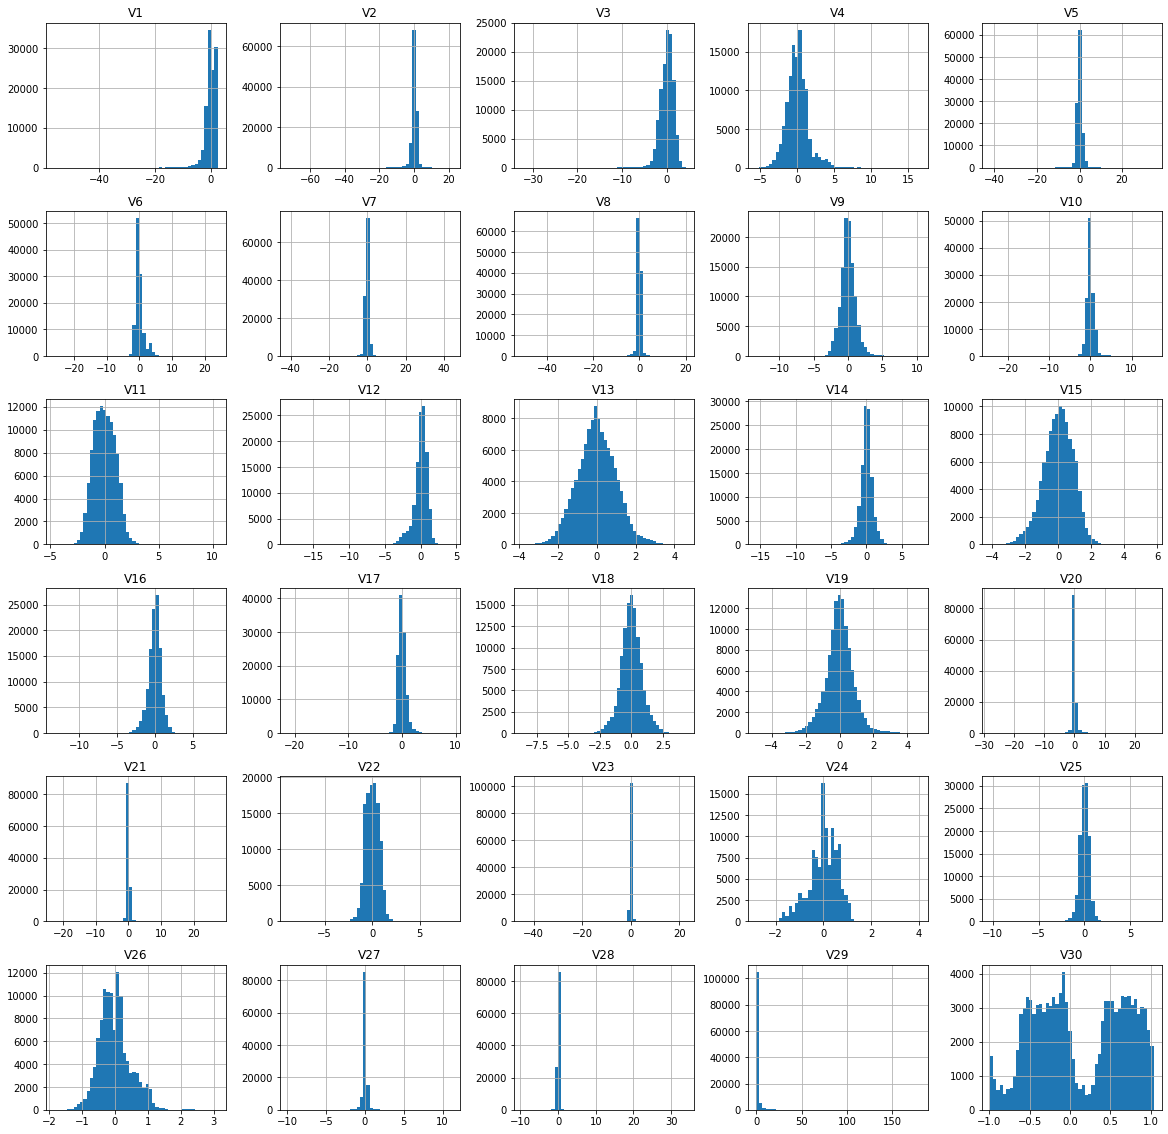

In [11]:
# train의 feature 분포
train_df.hist(bins=50, figsize=(20,20))
plt.show()

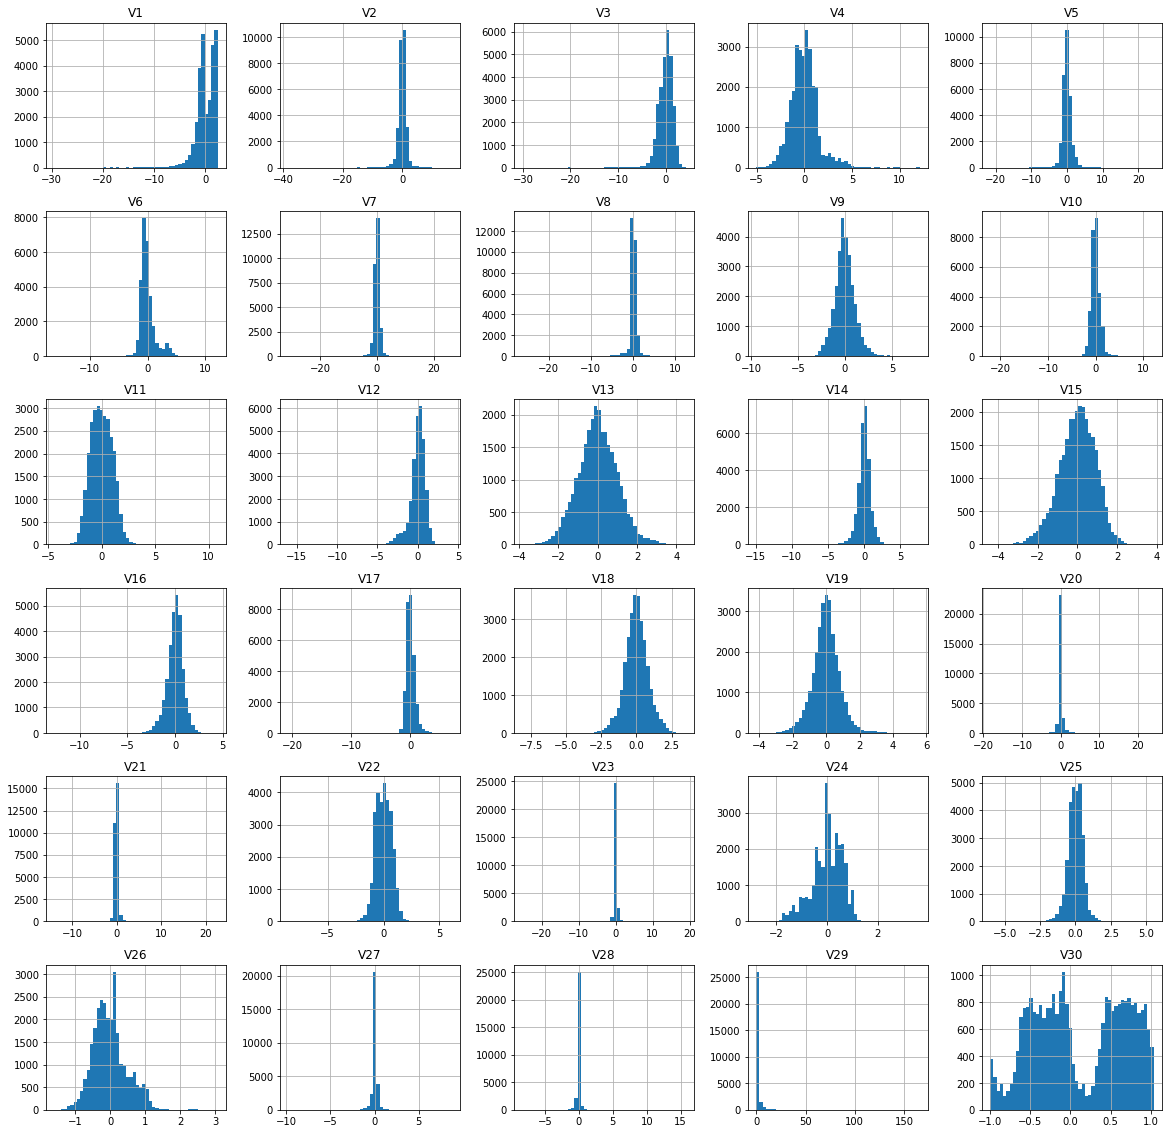

In [12]:
# val의 feature 분포
val_df.drop(columns=['Class']).hist(bins=50, figsize=(20,20))
plt.show()

## val의 정상, 사기 데이터 비율 파악

In [13]:
print('Non-Frauds:', round(val_df['Class'].value_counts()[0]/len(val_df) * 100, 2), '% of the dataset')
print('Frauds:', round(val_df['Class'].value_counts()[1]/len(val_df) * 100, 2), '% of the dataset')

Non-Frauds: 99.89 % of the dataset
Frauds: 0.11 % of the dataset


class 개수의 불균형이 심하면 제대로 된 상관관계 분석이 불가능하기 때문에,  
non-fraud 데이터를 샘플링하여 fraud:non-fraud 비율을 1:1로 동일하게 맞춘 뒤 상관 분석 진행

## 데이터 샘플링 후 fraud:non_fraud 비율 동일하게 맞추기

In [14]:
# 원본에 영향을 주지 않게 따로 복사본 제작
val_df_copy = val_df.copy()

# df.sample(frac=1): 전체 데이터를 SEED으로 shuffle해줌
val_df_copy = val_df_copy.sample(frac=1, random_state=SEED)

# fraud:non-fraud = 1:1이 되게 추출 후 concat
fraud_df = val_df_copy.loc[val_df_copy['Class'] == 1]
non_fraud_df = val_df_copy.loc[val_df_copy['Class'] == 0][:len(fraud_df)]
val_sampled_df = pd.concat([fraud_df, non_fraud_df])
new_val_df = val_sampled_df.sample(frac=1, random_state=SEED)

In [15]:
val_sampled_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
24742,-5.192496,3.164721,-5.047679,2.246597,-4.011781,-0.638908,-2.873463,1.576318,-2.861986,-2.120458,...,-1.006617,0.774562,0.063397,-0.390658,1.884741,-1.742558,-0.082216,3.156012,0.810172,1
14221,-1.430864,-0.802529,1.123320,0.389760,-0.281214,-0.055123,1.326232,0.195700,-0.546890,-0.713474,...,0.014002,0.844946,0.114963,0.156365,-0.619437,-0.120351,0.035594,4.643750,0.001140,1
641,0.316459,3.809076,-5.615159,6.047445,1.554026,-2.651353,-0.746579,0.055586,-2.678679,-4.959493,...,-0.511747,-0.583813,-0.219845,1.474753,0.491192,0.518868,0.402528,-0.293440,-0.906272,1
7702,-2.335655,2.225380,-3.379450,2.178538,-3.568264,0.316814,-1.734948,1.449139,-1.980033,-5.711505,...,0.297412,0.308536,-0.598416,-0.121850,-0.491018,0.701606,0.206966,5.899113,-0.325016,1
15054,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,-9.462573,-22.187089,...,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,-0.293440,0.113606,1
836,-1.426623,4.141986,-9.804103,6.666273,-4.749527,-2.073129,-10.089931,2.791345,-3.249516,-11.420451,...,0.407809,0.605809,-0.769348,-1.746337,0.502040,1.977258,0.711607,-0.293440,-0.864214,1
15027,-10.850282,6.727466,-16.760583,8.425832,-10.252697,-4.192171,-14.077086,7.168288,-3.683242,-15.239962,...,0.135535,-1.023967,0.406265,0.106593,-0.026232,-1.464630,-0.411682,0.782505,0.107708,1
71,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,7.084469,-0.989438,1
13706,-1.464897,1.975528,-1.077145,2.819191,0.069850,-0.789044,-1.196101,0.673654,-1.363724,-2.932895,...,-0.272505,-0.031549,-0.406166,0.157769,-0.104393,0.073796,-0.041570,-0.293440,-0.028231,1
677,0.857321,4.093912,-7.423894,7.380245,0.973366,-2.730762,-1.496497,0.543015,-2.351190,-3.944238,...,0.145400,0.240603,-0.234649,-1.004881,0.435832,0.618324,0.148469,-0.293440,-0.899012,1


In [16]:
new_val_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
11961,-2.693221,-0.266557,2.660421,-1.408162,-1.507387,-0.345395,0.042187,-0.327887,1.265545,1.864375,...,0.903468,-0.154041,0.988133,0.752659,-0.184467,0.576688,0.212617,1.243485,-0.104454,0
677,0.857321,4.093912,-7.423894,7.380245,0.973366,-2.730762,-1.496497,0.543015,-2.351190,-3.944238,...,0.145400,0.240603,-0.234649,-1.004881,0.435832,0.618324,0.148469,-0.293440,-0.899012,1
27998,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,-0.296793,0.994549,1
19985,0.128592,-0.231954,0.915882,-0.763705,0.367135,-0.709148,0.652381,-0.922014,-0.528638,1.405930,...,0.029804,-0.054301,-0.063319,-1.395135,0.469758,-0.497371,-0.410387,-0.167680,0.570578,0
14681,-0.201069,0.507942,-0.021236,-0.587214,0.737745,-1.499156,0.810475,-0.295225,0.248800,-0.449469,...,1.252971,-0.164149,0.056794,-0.858787,-0.323697,0.138847,0.250358,-0.293440,0.042258,0
6544,1.447743,-0.179019,-0.168095,-0.672327,-0.494184,-1.360098,0.077809,-0.497075,-1.384562,0.640818,...,0.607768,-0.184151,0.477402,0.845255,-0.090329,-0.019138,0.005497,-0.097813,-0.388433,0
15425,-4.221221,2.871121,-5.888716,6.890952,-3.404894,-1.154394,-7.739928,2.851363,-2.507569,-5.110728,...,1.567947,-0.578007,-0.059045,-1.829169,-0.072429,0.136734,-0.599848,-0.201355,0.210682,1
1201,-16.917468,9.669900,-23.736443,11.824990,-9.830548,-2.514829,-17.290657,1.820408,-6.264903,-12.916636,...,0.972755,1.241866,-1.051086,0.038009,0.672317,2.108471,-1.421243,-0.293440,-0.747730,1
28157,-0.773187,-0.354386,0.437607,-2.950758,-1.625546,0.510020,-1.696337,1.182913,-1.692329,0.587763,...,0.144423,0.151374,0.261723,-0.227395,-0.374307,-0.082646,-0.159494,0.195626,1.007519,0
13706,-1.464897,1.975528,-1.077145,2.819191,0.069850,-0.789044,-1.196101,0.673654,-1.363724,-2.932895,...,-0.272505,-0.031549,-0.406166,0.157769,-0.104393,0.073796,-0.041570,-0.293440,-0.028231,1


In [17]:
# 새로 만든 non_fraud, fraud 비율 파악

print('Distribution of the Classes in the subsample dataset')
print(new_val_df['Class'].value_counts()/len(new_val_df))
new_val_df.head()

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
11961,-2.693221,-0.266557,2.660421,-1.408162,-1.507387,-0.345395,0.042187,-0.327887,1.265545,1.864375,...,0.903468,-0.154041,0.988133,0.752659,-0.184467,0.576688,0.212617,1.243485,-0.104454,0
677,0.857321,4.093912,-7.423894,7.380245,0.973366,-2.730762,-1.496497,0.543015,-2.351190,-3.944238,...,0.145400,0.240603,-0.234649,-1.004881,0.435832,0.618324,0.148469,-0.293440,-0.899012,1
27998,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,-0.296793,0.994549,1
19985,0.128592,-0.231954,0.915882,-0.763705,0.367135,-0.709148,0.652381,-0.922014,-0.528638,1.405930,...,0.029804,-0.054301,-0.063319,-1.395135,0.469758,-0.497371,-0.410387,-0.167680,0.570578,0
14681,-0.201069,0.507942,-0.021236,-0.587214,0.737745,-1.499156,0.810475,-0.295225,0.248800,-0.449469,...,1.252971,-0.164149,0.056794,-0.858787,-0.323697,0.138847,0.250358,-0.293440,0.042258,0


## val feature 상관 분석 진행

데이터 불균형을 고려하지 않은 경우:

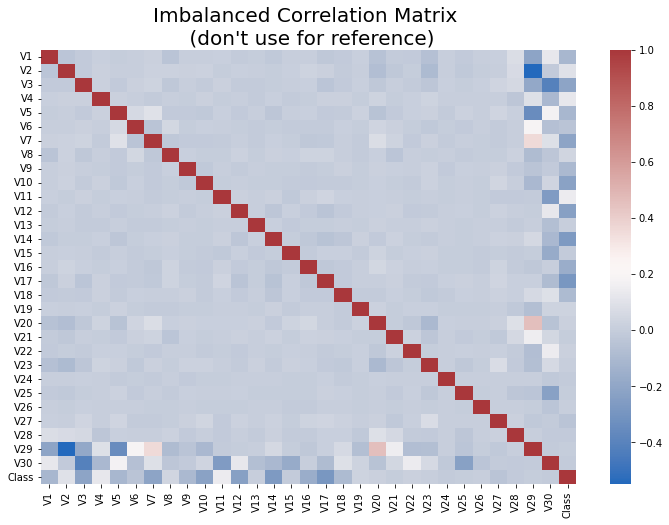

0 V17 -0.290434371492805
1 V14 -0.27085160614443726
2 V12 -0.2392641293375912
3 V10 -0.22681287222070776
4 V7 -0.21480970463957164
5 V3 -0.21234501819173615
6 V16 -0.1695415742288909
7 V5 -0.11225429282333912
8 V1 -0.10928376047620847
9 V9 -0.09866645577536803
10 V18 -0.09610430251769925
11 V6 -0.045675720550304666
12 V27 -0.04312713887826314
13 V28 -0.01815646790131095
14 V30 -0.010476260871101846
15 V24 -0.010131090067781318
16 V15 -0.009532241897718936
17 V25 -0.0035731276362305575
18 V29 -0.0017615910155675282
19 V21 -0.0010900720758479727
20 V13 0.0018000347614050647
21 V23 0.005015070204875703
22 V26 0.005371044243210362
23 V20 0.015873299556540498
24 V22 0.016995590913038122
25 V19 0.024223349309777445
26 V8 0.03835875719890502
27 V2 0.0968227317146988
28 V4 0.12614581534496366
29 V11 0.14208161409791742


In [18]:
# fraud:non_fraud 비율을 맞춰주지 않으면 나오는 상관관계
corr = val_df.corr()

# 전체 correlation matrix
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr, cmap='vlag', annot_kws={'size':20}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=20)
plt.show()

# Class와 다른 features 간의 상관계수 출력
for idx, (k,v) in enumerate(corr['Class'][:-1].sort_values().items()):
    print(idx, k, v)

데이터 불균형을 고려하여 비율을 맞춘 경우:

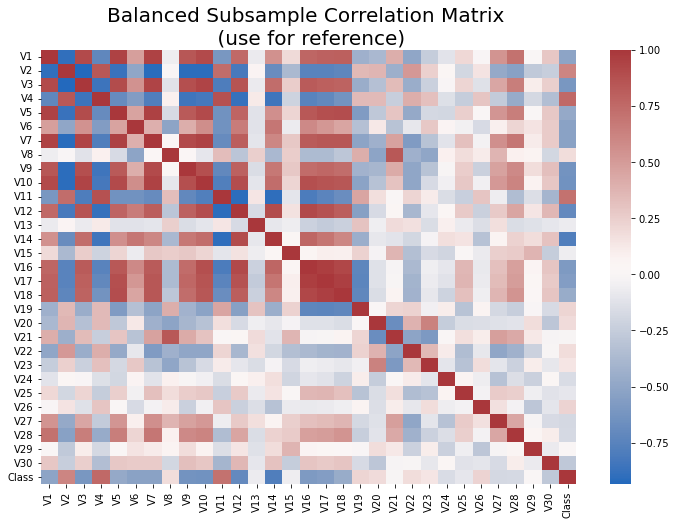

0 V14 -0.7838773264135148
1 V12 -0.7054180114439257
2 V10 -0.645090538658038
3 V9 -0.6364068934690595
4 V3 -0.6059230664900052
5 V16 -0.586085462697118
6 V17 -0.5609569775586769
7 V6 -0.5331626076257752
8 V7 -0.5268945061034775
9 V1 -0.5176759998644551
10 V5 -0.47516762320475103
11 V18 -0.4659087608663279
12 V30 -0.2837313922236932
13 V27 -0.18420667475991306
14 V28 -0.1741941411150005
15 V24 -0.15684080860899027
16 V25 -0.10190060420457298
17 V13 -0.07140923509364971
18 V15 -0.06000039974683972
19 V21 -0.012353179854912808
20 V29 0.011665121311283319
21 V23 0.14078589272297262
22 V22 0.1762497965859018
23 V8 0.1780643101405302
24 V20 0.18838292341270063
25 V19 0.2204526405140434
26 V26 0.22277573561449565
27 V2 0.6138289737896485
28 V11 0.7080618892247033
29 V4 0.7506552807205523


In [19]:
# 비율 맞춰준 Non-scaled set으로 파악한 상관관계
sub_sample_corr = new_val_df.corr()

# 전체 correlation matrix
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(sub_sample_corr, cmap='vlag', annot_kws={'size':20}, ax=ax)
ax.set_title("Balanced Subsample Correlation Matrix \n (use for reference)", fontsize=20)
plt.show()

# Class와 다른 features 간의 상관계수 출력
for idx, (k,v) in enumerate(sub_sample_corr['Class'][:-1].sort_values().items()):
    print(idx, k, v)

# Preprocessing

## 상관 분석에 따른 변수 선택

In [20]:
key_reverse = list(sub_sample_corr['Class'][:-1].sort_values().keys())

# 위에 출력된 상관계수를 기준으로 변수 선택
use_columns_8 = key_reverse[:5] + key_reverse[-3:] # 상관계수 절댓값 0.6 이상
use_columns_13 = key_reverse[:10] + key_reverse[-3:] # 상관계수 절댓값 0.5 이상
use_columns_15 = key_reverse[:12] + key_reverse[-3:] # 상관계수 절댓값 0.4 이상

print('상관계수 절대값이 0.6 이상인 상위 8개 column:', use_columns_8)
print('상관계수 절대값이 0.5 이상인 상위 13개 column:', use_columns_13)
print('상관계수 절대값이 0.4 이상인 상위 15개 column:', use_columns_15)

상관계수 절대값이 0.6 이상인 상위 8개 column: ['V14', 'V12', 'V10', 'V9', 'V3', 'V2', 'V11', 'V4']
상관계수 절대값이 0.5 이상인 상위 13개 column: ['V14', 'V12', 'V10', 'V9', 'V3', 'V16', 'V17', 'V6', 'V7', 'V1', 'V2', 'V11', 'V4']
상관계수 절대값이 0.4 이상인 상위 15개 column: ['V14', 'V12', 'V10', 'V9', 'V3', 'V16', 'V17', 'V6', 'V7', 'V1', 'V5', 'V18', 'V2', 'V11', 'V4']


각 변수별 데이터셋 생성:

In [21]:
# correlation 0.6 이상인 8개 column을 뽑은 데이터셋
train_df_8 = train_df[use_columns_8]
val_df_8 = val_df[use_columns_8 + ['Class']]
val_df_8

,V14,V12,V10,V9,V3,V2,V11,V4,Class
0,-0.443523,0.836390,-0.366846,-0.736727,1.044367,1.119593,1.017614,-0.222187,0
1,0.983739,0.406774,0.724396,-1.191311,-0.171479,0.328461,1.690330,2.109204,0
2,0.788864,-0.660863,0.757952,-0.896287,0.194008,0.575068,-0.448937,2.598192,0
3,0.314166,1.385160,-0.225495,0.226278,0.387585,-0.323684,1.944545,0.544474,0
4,-2.837136,0.066851,6.051521,4.009259,1.483691,2.600138,2.572500,-2.418473,0
...,...,...,...,...,...,...,...,...,...
28457,1.018502,0.748099,-0.077753,-1.099446,-0.313252,1.433992,0.534689,0.926044,0
28458,-0.317789,0.162691,-1.245088,-0.730854,-0.907599,0.588379,0.874312,-0.418847,0
28459,0.753473,-0.690868,0.076605,-0.417116,-0.168583,1.302212,-1.291228,0.981577,0
28460,0.626211,0.559047,0.267772,0.435402,-1.196825,-0.175233,0.523316,0.234580,0


In [22]:
# correlation 0.5 이상인 13개 column을 뽑은 데이터셋
train_df_13 = train_df[use_columns_13]
val_df_13 = val_df[use_columns_13 + ['Class']]
val_df_13

,V14,V12,V10,V9,V3,V16,V17,V6,V7,V1,V2,V11,V4,Class
0,-0.443523,0.836390,-0.366846,-0.736727,1.044367,0.739453,-0.540980,-0.246761,0.651583,-0.338262,1.119593,1.017614,-0.222187,0
1,0.983739,0.406774,0.724396,-1.191311,-0.171479,-0.602232,0.402484,1.696038,0.107712,0.962496,0.328461,1.690330,2.109204,0
2,0.788864,-0.660863,0.757952,-0.896287,0.194008,0.295404,-0.287878,-1.044430,0.531588,1.145524,0.575068,-0.448937,2.598192,0
3,0.314166,1.385160,-0.225495,0.226278,0.387585,-1.333716,1.002869,1.650358,-0.427576,0.927060,-0.323684,1.944545,0.544474,0
4,-2.837136,0.066851,6.051521,4.009259,1.483691,-0.303774,-1.942303,-0.824575,2.065426,-3.005237,2.600138,2.572500,-2.418473,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28457,1.018502,0.748099,-0.077753,-1.099446,-0.313252,-0.914161,0.143397,-0.565669,1.066075,-0.546378,1.433992,0.534689,0.926044,0
28458,-0.317789,0.162691,-1.245088,-0.730854,-0.907599,0.482847,0.681412,-0.760802,0.758545,-0.764523,0.588379,0.874312,-0.418847,0
28459,0.753473,-0.690868,0.076605,-0.417116,-0.168583,-1.129904,0.319074,-0.605641,1.253430,-0.446951,1.302212,-1.291228,0.981577,0
28460,0.626211,0.559047,0.267772,0.435402,-1.196825,0.225361,-0.605252,-0.726571,0.017050,2.039560,-0.175233,0.523316,0.234580,0


In [23]:
# correlation 0.4 이상인 15개 column을 뽑은 데이터셋
train_df_15 = train_df[use_columns_15]
val_df_15 = val_df[use_columns_15 + ['Class']]
val_df_15

,V14,V12,V10,V9,V3,V16,V17,V6,V7,V1,V5,V18,V2,V11,V4,Class
0,-0.443523,0.836390,-0.366846,-0.736727,1.044367,0.739453,-0.540980,-0.246761,0.651583,-0.338262,0.499361,0.476677,1.119593,1.017614,-0.222187,0
1,0.983739,0.406774,0.724396,-1.191311,-0.171479,-0.602232,0.402484,1.696038,0.107712,0.962496,1.129566,-1.737162,0.328461,1.690330,2.109204,0
2,0.788864,-0.660863,0.757952,-0.896287,0.194008,0.295404,-0.287878,-1.044430,0.531588,1.145524,-0.092210,-0.451453,0.575068,-0.448937,2.598192,0
3,0.314166,1.385160,-0.225495,0.226278,0.387585,-1.333716,1.002869,1.650358,-0.427576,0.927060,0.246787,-2.119314,-0.323684,1.944545,0.544474,0
4,-2.837136,0.066851,6.051521,4.009259,1.483691,-0.303774,-1.942303,-0.824575,2.065426,-3.005237,0.306326,-0.435450,2.600138,2.572500,-2.418473,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28457,1.018502,0.748099,-0.077753,-1.099446,-0.313252,-0.914161,0.143397,-0.565669,1.066075,-0.546378,0.522388,0.154285,1.433992,0.534689,0.926044,0
28458,-0.317789,0.162691,-1.245088,-0.730854,-0.907599,0.482847,0.681412,-0.760802,0.758545,-0.764523,0.901528,0.486991,0.588379,0.874312,-0.418847,0
28459,0.753473,-0.690868,0.076605,-0.417116,-0.168583,-1.129904,0.319074,-0.605641,1.253430,-0.446951,0.578957,-0.201862,1.302212,-1.291228,0.981577,0
28460,0.626211,0.559047,0.267772,0.435402,-1.196825,0.225361,-0.605252,-0.726571,0.017050,2.039560,-0.008713,-0.163049,-0.175233,0.523316,0.234580,0


## 데이터셋 생성
데이터셋은 pytorch의 `Dataset`을 상속받는 class를 정의하여 생성  
데이터로더는 pytorch의 `DataLoader`를 사용  

다음과 같이 총 4개의 데이터셋과 데이터로더를 생성  
- val에서 파악한 상관계수 절대값 0.6 이상 column(8개) 사용
- val에서 파악한 상관계수 절대값 0.5 이상 column(13개) 사용
- val에서 파악한 상관계수 절대값 0.4 이상 column(15개) 사용
- 전체 column(30개) 사용

In [24]:
# 데이터셋 생성 class 및 함수 정의

class MyDataset(Dataset):
    
    # 데이터셋의 전처리를 수행하는 부분
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        if self.eval_mode: # 'Class' column이 있는 경우에만 작동
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
            
    # 데이터셋에서 특정 1개의 샘플을 가져오는 부분
    def __getitem__(self, index):
        if self.eval_mode: # 'Class' column이 있는 경우에만 작동
            self.x = self.df[index]
            self.y = self.labels[index]
            return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)
        
    # 데이터셋의 길이, 즉 '총 샘플의 수'를 계산하는 부분
    def __len__(self):
        return len(self.df)

In [25]:
# 데이터셋 생성 및 데이터로더로 데이터 호출
# 앞에서 설정한 BS(배치 사이즈) 사용

# 8개 column
train_dataset_8 = MyDataset(df=train_df_8, eval_mode=False)
val_dataset_8 = MyDataset(df=val_df_8, eval_mode=True)
train_loader_8 = DataLoader(train_dataset_8, batch_size=BS, shuffle=True, num_workers=6)
val_loader_8 = DataLoader(val_dataset_8, batch_size=BS, shuffle=False, num_workers=6)

# 13개 column
train_dataset_13 = MyDataset(df=train_df_13, eval_mode=False)
val_dataset_13 = MyDataset(df=val_df_13, eval_mode=True)
train_loader_13 = DataLoader(train_dataset_13, batch_size=BS, shuffle=True, num_workers=6)
val_loader_13 = DataLoader(val_dataset_13, batch_size=BS, shuffle=False, num_workers=6)

# 15개 column
train_dataset_15 = MyDataset(df=train_df_15, eval_mode=False)
val_dataset_15 = MyDataset(df=val_df_15, eval_mode=True)
train_loader_15 = DataLoader(train_dataset_15, batch_size=BS, shuffle=True, num_workers=6)
val_loader_15 = DataLoader(val_dataset_15, batch_size=BS, shuffle=False, num_workers=6)

# 전체 column
train_dataset = MyDataset(df=train_df, eval_mode=False)
val_dataset = MyDataset(df=val_df, eval_mode=True)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=6)

# Modeling

## Overcomplete AutoEncoder 사용

**AutoEncoder**: 비지도학습 방식으로 훈련된 인공 신경망, 이상치 탐지에 자주 사용되는 모델  

오토인코더는 크게 아래 두 부분이 **대칭**을 이루며 구성되어 있음
- **인코더(Encoder)**: 인지 네트워크(recognition network)라고도 하며, **입력을 내부 표현으로 변환**하는 기능 수행  
- **디코더(Decoder)**: 생성 네트워크(generative network)라고도 하며, **내부 표현을 출력으로 변환**하는 기능 수행  

<이상치를 탐지하는 방법>  
디코더를 통해 **재구성(reconstruction)**된 출력과 입력의 차이를 계산하면 reconstruction error가 얻어지는데, AutoEncoder의 학습(parameter update)은 이 reconstruction error를 줄이는 방향으로 이뤄짐. 이 과정에서 새로운 데이터가 들어왔을 때 유독 reconstructon error가 크게 측정되므로 이것을 anomaly, 즉 이상치로 판단하는 식으로 작동함  

**Overcomplete AutoEncoder**: 일반적인 AutoEncoder는 <u>Encoder에서 차원이 축소되고 Decoder에서 다시 원래 차원으로 늘려주는데</u>, 현재 데이터셋은 차원이 30으로 일반적으로 등장하는 32, 64, 128에 비해 차원이 작기 때문에 **<u>Encoder에서 차원을 늘려주고 Decoder에서 다시 원래 차원으로 줄여</u>** 입력 데이터를 잘 나타내는 특징을 얻는 방식인 **Overcomplete AutoEncoder**를 사용하였음

### class AutoEncoder 정의
기능: 모델의 큰 틀, 인코더(Encoder), 디코더(Decoder)의 차원 및 깊이 설정

In [26]:
# 선택한 데이터셋에 맞게 최초 입력과 최종 출력 차원을 달리 설정해주어야 함

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.Encoder = nn.Sequential(nn.Linear(15, 64), # 최초 입력
                                    nn.BatchNorm1d(64),
                                    nn.ReLU(),
                                    nn.Linear(64, 128),
                                    nn.BatchNorm1d(128),
                                    nn.ReLU())
        
        # Decoder
        self.Decoder = nn.Sequential(nn.Linear(128, 64),
                                    nn.BatchNorm1d(64),
                                    nn.ReLU(),
                                    nn.Linear(64, 15)) # 최종 출력
        
    def forward(self, x):
        x = self.Encoder(x) # Encoder 적용
        x = self.Decoder(x) # Decoder 적용
        return x

### class Trainer 정의  
기능: 모델 학습을 위한 초기 세팅(init), 학습(fit), 검증(validation)  

validation 함수에 있는 코사인 유사도 관련 설명:  
- 코사인 유사도는 -1~1 사이의 값을 가짐
- 벡터들이 완전히 다를 경우 -1, 방향이 완전히 동일하면 1
- 즉 1일수록 거의 유사하다고 판단 가능
- 아래 코드에서는 코사인 유사도가 thr(0.95)보다 작은 경우 이상치(1), 아닌 경우 정상(0)으로 판단하고 있음

In [27]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        self.criterion = nn.L1Loss().to(self.device) # L1 손실함수 사용
    
    # 학습(앞에서 설정한 EPOCHS(반복 횟수) 사용)
    def fit(self):
        self.model.to(self.device)
        best_score = 0
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad() # gradient 0 초기화(pytorch에서 필수!)
                
                _x = self.model(x) # x: input, _x: output
                loss = self.criterion(x, _x) # 손실 계산
                
                loss.backward() # 손실에 대해 역전파 알고리즘으로 각 가중치에 대한 gradient 계산
                self.optimizer.step() # 계산한 gradient를 바탕으로 모델의 최적화 진행
                
                train_loss.append(loss.item())
                
            score = self.validation(self.model, 0.95) # 아래에서 정의할 함수 사용
            print(f'Epoch: [{epoch}] Train loss: [{np.mean(train_loss)}] Val Score: [{score}]')
            
            if self.scheduler is not None:
                self.scheduler.step(score)
            
            # 가장 좋은 성능일 때 모델 중간 저장
            if best_score < score:
                best_score = score
                torch.save(model.module.state_dict(), './model/best_autoencoder_model.pth',
                          _use_new_zipfile_serialization=False)
    
    # 검증
    def validation(self, eval_model, thr):
        cos = nn.CosineSimilarity(dim=1, eps=1e-6) # 코사인 유사도 사용
        eval_model.eval()
        pred, true = [], []
        with torch.no_grad():
            for x,y in iter(self.val_loader):
                x = x.float().to(self.device)
                
                _x = self.model(x)
                diff = cos(x, _x).cpu().tolist()
                batch_pred = np.where(np.array(diff) < thr, 1, 0).tolist()
                pred += batch_pred
                true += y.tolist()
        
        return f1_score(true, pred, average='macro')

### 모델 학습

In [28]:
# 앞에서 설정한 LR(학습률) 사용

model = nn.DataParallel(AutoEncoder()) # 데이터 병렬 처리
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                      factor=0.5, patience=10,
                                                      threshold_mode='abs',
                                                      min_lr=1e-8, verbose=True)

# 15개 column 사용
trainer = Trainer(model, optimizer, train_loader_15, val_loader_15, scheduler, device)
trainer.fit()

Epoch: [0] Train loss: [0.5609174200466701] Val Score: [0.07165471321075044]
Epoch: [1] Train loss: [0.28224544865744455] Val Score: [0.420144774131936]
Epoch: [2] Train loss: [0.1897579367671694] Val Score: [0.502513549931138]
Epoch: [3] Train loss: [0.1482821192060198] Val Score: [0.5917179262371195]
Epoch: [4] Train loss: [0.12403425787176404] Val Score: [0.6844368008149726]
Epoch: [5] Train loss: [0.10785391607454844] Val Score: [0.8045965667777433]
Epoch: [6] Train loss: [0.09765858096735817] Val Score: [0.8519279892324237]
Epoch: [7] Train loss: [0.09234331973961421] Val Score: [0.890501890608512]
Epoch: [8] Train loss: [0.08909473674637931] Val Score: [0.8967110829723166]
Epoch: [9] Train loss: [0.08559285636459078] Val Score: [0.9031202878275757]
Epoch: [10] Train loss: [0.08101813601596015] Val Score: [0.9165787375726882]
Epoch: [11] Train loss: [0.08110931835004262] Val Score: [0.9165787375726882]
Epoch: [12] Train loss: [0.07995194835322243] Val Score: [0.9165787375726882]
E

### 모델 예측

In [29]:
# 학습하여 저장된 모델 상태 출력

model = AutoEncoder()
model.load_state_dict(torch.load('./model/best_autoencoder_model.pth'))
model = nn.DataParallel(model)
model.eval()

DataParallel(
  (module): AutoEncoder(
    (Encoder): Sequential(
      (0): Linear(in_features=15, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (Decoder): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=15, bias=True)
    )
  )
)

In [30]:
# test 데이터 로드 후 'ID' column 제거

test_df = pd.read_csv('./data/test.csv')
test_df.drop(columns=['ID'], inplace=True)
test_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,0.309755,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142498,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,-0.111640,...,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,0.028645,1.034904
142499,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,-0.594242,...,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,0.810312,1.034916
142500,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.038986,1.034963
142501,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.641096,1.034975


In [31]:
# 15개 column으로 변환

test_df_15 = test_df[use_columns_15]
test_df_15

,V14,V12,V10,V9,V3,V16,V17,V6,V7,V1,V5,V18,V2,V11,V4
0,-0.311169,-0.617801,0.090794,0.363787,2.536347,-0.470401,0.207971,0.462388,0.239599,-1.359807,-0.338321,0.025791,-0.072781,-0.551600,1.378155
1,-0.143772,1.065235,-0.166974,-0.255425,0.166480,0.463917,-0.114805,-0.082361,-0.078803,1.191857,0.060018,-0.183361,0.266151,1.612727,0.448154
2,-1.119670,0.538196,0.753074,0.817739,1.548718,-0.451449,-0.237033,0.095921,0.592941,-1.158233,-0.407193,-0.038195,0.877737,-0.822843,0.403034
3,0.167372,-0.153826,-0.099254,0.464960,0.045371,-0.443587,0.002821,0.272708,-0.005159,1.229658,0.191881,-0.611987,0.141004,-1.416907,1.202613
4,0.362832,-0.326143,0.309755,-0.558895,-0.874300,-0.129487,-0.809979,3.317027,0.470455,0.384978,2.924584,0.359985,0.616109,-0.259116,-0.094019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142498,1.122674,-0.453235,-0.111640,-0.285670,-0.635891,-1.431897,0.939328,-1.014307,0.427126,0.219529,-0.152971,-0.002373,0.881246,-1.109232,0.960928
142499,-0.858719,0.453596,-0.594242,1.159498,1.189786,-0.644646,0.447184,5.519980,-1.518185,-1.775135,1.196063,0.388721,-0.004235,-1.264072,0.331096
142500,-0.675143,0.915802,-0.975926,0.584800,2.035030,-0.711757,-0.025693,1.058415,0.024330,-0.732789,0.868229,-1.221179,-0.055080,-0.150189,-0.738589
142501,-0.510602,0.063119,-0.484782,0.432454,-3.249640,0.140716,0.313502,3.031260,-0.296827,1.919565,2.630515,0.395652,-0.301254,0.411614,-0.557828


In [32]:
# 데이터셋 생성 및 데이터로더로 데이터 호출
# 앞에서 설정한 BS(배치 사이즈) 사용

test_dataset_15 = MyDataset(test_df_15, eval_mode=False)
test_loader_15 = DataLoader(test_dataset_15, batch_size=BS, shuffle=False, num_workers=6)

In [33]:
# 예측을 위한 함수 정의
# 형태가 Trainer 클래스의 validation 함수와 거의 흡사

def prediction(model, thr, test_loader, device):
    model.to(device)
    model.eval()
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    pred = []
    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            
            _x = model(x)
            diff = cos(x, _x).cpu().tolist()
            batch_pred = np.where(np.array(diff) < thr, 1, 0).tolist()
            pred += batch_pred
    
    return pred

In [34]:
preds = prediction(model, 0.95, test_loader_15, device)

# Result

In [35]:
preds

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


## 예측 결과물 submit

In [36]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.head()

,ID,Class
0,AAAA0x1,1
1,AAAA0x2,1
2,AAAA0x5,1
3,AAAA0x7,1
4,AAAA0xc,1


In [37]:
submit['Class'] = preds
submit.head()

,ID,Class
0,AAAA0x1,0
1,AAAA0x2,0
2,AAAA0x5,0
3,AAAA0x7,0
4,AAAA0xc,0


In [38]:
submit.to_csv('./predictions/autoencoder_prediction.csv', index=False)

# END